#### Importing all the required packages

In [51]:
import requests
import folium
import urllib
from pandas.io.json import json_normalize
import pandas as pd
import folium
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer
import os
import pdal
from osgeo import gdal
import json
from ipywidgets import interact
from ipywidgets import widgets
import imageio
import pathlib
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
import laspy
import rasterio
from rasterio import mask
from glob import glob
from shapely.geometry import box
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import re
from shapely.geometry import Polygon, Point, mapping
from pyproj import Proj, transform
import warnings
warnings.filterwarnings("ignore")

In [2]:
public_data_path = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/ept.json"

In [59]:
def read_text(text_path):
    text = []
    with open(text_path) as fp:
        line = fp.readline()
        while line:
            line = line.rstrip("\n")
            text.append(line)
            line = fp.readline()
    return text

In [60]:
sys.path.append("../")
area_names= read_text('../data/filename.txt')

In [61]:
area_names

['AK_BrooksCamp_2012/',
 'AK_Coastal_2009/',
 'AK_Fairbanks-NSBorough_2010/',
 'AK_Juneau_2012/',
 'AK_Kenai_2008/',
 'AK_MatanuskaSusitna-Lot1_2011/',
 'AK_MatanuskaSusitna-Lot2_2011/',
 'AK_NomeCreek_2010/',
 'AK_NorthSlope_B10_2018/',
 'AK_NorthSlope_B11_2018/',
 'AK_NorthSlope_B12_2018/',
 'AK_NorthSlope_B13_2018/',
 'AK_NorthSlope_B14_2018/',
 'AK_NorthSlope_B1_2018/',
 'AK_NorthSlope_B2_2018/',
 'AK_NorthSlope_B3_2018/',
 'AK_NorthSlope_B4_2018/',
 'AK_NorthSlope_B5_2018/',
 'AK_NorthSlope_B6_2018/',
 'AK_NorthSlope_B7_2018/',
 'AK_NorthSlope_B8_2018/',
 'AK_NorthSlope_B9_2018/',
 'AK_ValdezB_2007/',
 'AK_Valdez_2007/',
 'AK_YukonFlats_2009/',
 'AL_25Co_TL_2017/',
 'AL_BaldwinCo-East_2011/',
 'AL_BaldwinCo-West_2011/',
 'AL_BlountCo_2010/',
 'AL_ColbertLauderdale_2011/',
 'AL_NorthAL_2019/',
 'AL_TriCounty_2010/',
 'AR-TN_NRCS_CaneCreek_2010/',
 'AR-TN_NRCS_Sharkey_2010/',
 'ARRA-AK_EkluntaGlacier_2010/',
 'ARRA-AL_MobileBay_2010/',
 'ARRA-AL_TennesseeRiver_2010/',
 'ARRA-CA_Cent

In [6]:
def get_name_and_year( resource_location: str) -> tuple:
    """ Extracts year and region from EPT resource location.
    Args:
        resource_location (str): Name of EPT resource location 
    Returns:
        tuple: A tuple containing the name of the region and year
    """
    resource_location = resource_location.replace('/', '')
    regex = '20[0-9][0-9]+'
    match = re.search(regex, resource_location)
    if(match):
      return (resource_location[:match.start() - 1], resource_location[match.start():match.end()])
    else:
      return (resource_location, None)

In [7]:
for area in area_names:
    print(get_name_and_year(f"{area}"))

('AK_BrooksCamp', '2012')
('AK_Coastal', '2009')
('AK_Fairbanks-NSBorough', '2010')
('AK_Juneau', '2012')
('AK_Kenai', '2008')
('AK_MatanuskaSusitna-Lot1', '2011')
('AK_MatanuskaSusitna-Lot2', '2011')
('AK_NomeCreek', '2010')
('AK_NorthSlope_B10', '2018')
('AK_NorthSlope_B11', '2018')
('AK_NorthSlope_B12', '2018')
('AK_NorthSlope_B13', '2018')
('AK_NorthSlope_B14', '2018')
('AK_NorthSlope_B1', '2018')
('AK_NorthSlope_B2', '2018')
('AK_NorthSlope_B3', '2018')
('AK_NorthSlope_B4', '2018')
('AK_NorthSlope_B5', '2018')
('AK_NorthSlope_B6', '2018')
('AK_NorthSlope_B7', '2018')
('AK_NorthSlope_B8', '2018')
('AK_NorthSlope_B9', '2018')
('AK_ValdezB', '2007')
('AK_Valdez', '2007')
('AK_YukonFlats', '2009')
('AL_25Co_TL', '2017')
('AL_BaldwinCo-East', '2011')
('AL_BaldwinCo-West', '2011')
('AL_BlountCo', '2010')
('AL_ColbertLauderdale', '2011')
('AL_NorthAL', '2019')
('AL_TriCounty', '2010')
('AR-TN_NRCS_CaneCreek', '2010')
('AR-TN_NRCS_Sharkey', '2010')
('ARRA-AK_EkluntaGlacier', '2010')
('ARR

In [9]:
data_json

{'bounds': [-15730544, 10937407, -19027, -15691854, 10976097, 19663],
 'boundsConforming': [-15730543, 10941090, -3, -15691855, 10972414, 638],
 'dataType': 'laszip',
 'hierarchyType': 'json',
 'points': 55711772,
 'schema': [{'name': 'X',
   'offset': -15711199,
   'scale': 0.01,
   'size': 4,
   'type': 'signed'},
  {'name': 'Y',
   'offset': 10956752,
   'scale': 0.01,
   'size': 4,
   'type': 'signed'},
  {'name': 'Z', 'offset': 318, 'scale': 0.01, 'size': 4, 'type': 'signed'},
  {'name': 'Intensity', 'size': 2, 'type': 'unsigned'},
  {'name': 'ReturnNumber', 'size': 1, 'type': 'unsigned'},
  {'name': 'NumberOfReturns', 'size': 1, 'type': 'unsigned'},
  {'name': 'ScanDirectionFlag', 'size': 1, 'type': 'unsigned'},
  {'name': 'EdgeOfFlightLine', 'size': 1, 'type': 'unsigned'},
  {'name': 'Classification', 'size': 1, 'type': 'unsigned'},
  {'name': 'ScanAngleRank', 'size': 4, 'type': 'float'},
  {'name': 'UserData', 'size': 1, 'type': 'unsigned'},
  {'name': 'PointSourceId', 'size': 

In [8]:
PUBLIC_ACCESS_PATH= "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"

In [62]:
class Lidar():
    def __init__(self):
        self.text_path = '../data/filename.txt'
        self.PUBLIC_DATA = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"
        self.output_file = 'spatial_subset.geojson'
        
    def region(self):
        '''
        Function to display a slider for picking the desired region to 
        '''
        self.output_slider_variable = widgets.Text()
                
        # Define function to bind value of the input to the output variable 
        def f(x):
            self.output_slider_variable.value = str(x)

        dropdown = interact(f, x=read_text(self.text_path))
        return self.output_slider_variable

    def ept_json(self):
        '''
        Define a function to combine the public data path with the region specified then append the ept.json format.
        '''
        self.new_variable = str(self.output_slider_variable.value)
        self.PUBLIC_ACCESS_PATH = self.PUBLIC_DATA + self.new_variable + "ept.json"
        return self.PUBLIC_ACCESS_PATH
    
    def pipeline(self, xmin, xmax, ymin, ymax):
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        xmin, ymax = transformer.transform(xmin, ymax)
        xmax, ymin = transformer.transform(xmax, ymin)
        self.pdal_aoi_bounds = f"([{xmin}, {xmax}], [{ymin}, {ymax}])"
        return self.pdal_aoi_bounds
        
    ## Define a function for running a pdal pipeline and returning the filename as output
    def run_pipeline(self):
        pipeline_def =  [
        {
            "bounds": self.pdal_aoi_bounds,
            "filename": self.PUBLIC_ACCESS_PATH,
            "type": "readers.ept",
            "tag": "readdata"
        },
        {
            "limits": "Classification![2:7], Classification![9:9]",
            "type": "filters.range",
            "tag": "nonoise"
        },
        {
            "filename": "spatial_subset.laz",
            "inputs": [ "nonoise" ],
            "tag": "writerslas",
            "type": "writers.las"
        },
       {
            "filename": "spatial_subset.tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "inputs": [ "writerslas" ],
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
        },
        {
        "type" : "writers.text",
        "format": "geojson",
        "write_header": True
        }
    ]
    
        output_file = self.output_file
        pipeline_def[-1]["filename"] = output_file
        pipeline_json =  json.dumps(pipeline_def)
        pipeline = pdal.Pipeline(pipeline_json)

        # remove the output file before building a new one
        if os.path.exists(output_file):
            os.remove(output_file)

        count = pipeline.execute()
        data = open(output_file, 'r').read()
        data = data.replace("[,{", "[{").replace("}{", "},{")
        open(output_file, 'w').write(data)
        return output_file
    
    def geodf(self, geojsonfile):
        df = gpd.read_file(geojsonfile)
        geometry = [Point(xy) for xy in zip(pd.to_numeric(df['X']), pd.to_numeric(df['Y']))]
        gdf = gpd.GeoDataFrame(df, crs='epsg:4326',geometry=geometry)
        gdf = gdf[["Z", "geometry"]]
        gdf = gdf.rename(columns={"Z": "elevation_m", "geometry": "geometry"})
        return gdf
    
    def plot_raster(self, rasterfile):
        dataset = gdal.Open(rasterfile)
        band1 = dataset.GetRasterBand(1)
        self.b1 = band1.ReadAsArray()
        img = self.b1
        f = plt.figure()
        plt.imshow(img)
        cbar = plt.colorbar()
        plt.savefig('Tiff.png')
        plt.show()
        
    def plot3d(self):
        #create meshgrid
        X, Y = np.meshgrid(np.linspace(0, 2, 982), np.linspace(0, 2, len(self.b1)))
        # Plot surface
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, self.b1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
        ax.set_title('surface')
    
        

In [63]:
y=Lidar()

In [64]:
y.region()

interactive(children=(Dropdown(description='x', options=('AK_BrooksCamp_2012/', 'AK_Coastal_2009/', 'AK_Fairba…

Text(value='AK_BrooksCamp_2012/')

In [65]:
y.ept_json()

'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json'

In [66]:
y.pipeline(xmin = -93.756155,xmax = -93.747334, ymin = 41.918015, ymax = 41.921429)

'([-10436887.43333523, -10435905.484106943], [5148706.389047224, 5149217.145836504])'

In [67]:
y.run_pipeline()

'spatial_subset.geojson'

In [68]:
y.geodf('spatial_subset.geojson')

elevation_m                               geometry
0          311.350  POINT (-10436767.07000 5148706.98000)
1          311.550  POINT (-10436761.60000 5148707.73000)
2          311.670  POINT (-10436760.26000 5148707.91000)
3          311.700  POINT (-10436758.88000 5148708.11000)
4          311.860  POINT (-10436756.13000 5148708.47000)
...            ...                                    ...
403326     317.360  POINT (-10436010.23000 5149162.72000)
403327     317.340  POINT (-10436009.16000 5149162.87000)
403328     317.460  POINT (-10436005.72000 5149163.33000)
403329     317.590  POINT (-10436044.44000 5149165.12000)
403330     314.960  POINT (-10436766.08000 5149170.88000)

[403331 rows x 2 columns]

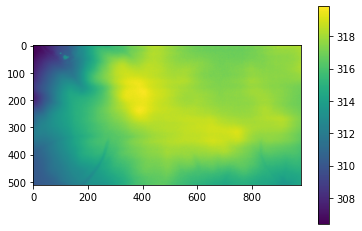

In [69]:
y.plot_raster('spatial_subset.tif')

## Plotting 3D 

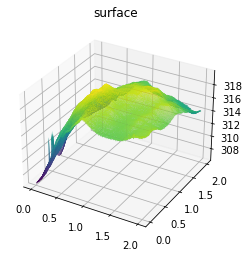

In [70]:
y.plot3d()